In [1]:
# ECEN Data Mining Project – KMNIST end-to-end code

# 1. Data Preparation – Imports, reproducibility, device

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

from torchvision.datasets import KMNIST
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# Reproducibility and device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [2]:
# 1. Data Preparation – Load KMNIST data (from NPZ if present, otherwise from torchvision)

def load_kmnist_npz_or_download():
    if (
        os.path.exists("kmnist-train-imgs.npz")
        and os.path.exists("kmnist-train-labels.npz")
        and os.path.exists("kmnist-test-imgs.npz")
        and os.path.exists("kmnist-test-labels.npz")
    ):
        train_imgs = np.load("kmnist-train-imgs.npz")["arr_0"]
        train_labels = np.load("kmnist-train-labels.npz")["arr_0"]
        test_imgs = np.load("kmnist-test-imgs.npz")["arr_0"]
        test_labels = np.load("kmnist-test-labels.npz")["arr_0"]
    else:
        transform = transforms.ToTensor()
        train_dataset = KMNIST(root="./data", train=True, download=True, transform=transform)
        test_dataset = KMNIST(root="./data", train=False, download=True, transform=transform)
        train_imgs = (train_dataset.data.numpy()).astype(np.uint8)
        train_labels = train_dataset.targets.numpy()
        test_imgs = (test_dataset.data.numpy()).astype(np.uint8)
        test_labels = test_dataset.targets.numpy()
        np.savez("kmnist-train-imgs.npz", arr_0=train_imgs)
        np.savez("kmnist-train-labels.npz", arr_0=train_labels)
        np.savez("kmnist-test-imgs.npz", arr_0=test_imgs)
        np.savez("kmnist-test-labels.npz", arr_0=test_labels)
    return train_imgs, train_labels, test_imgs, test_labels

train_imgs, train_labels, test_imgs, test_labels = load_kmnist_npz_or_download()

print("Train images:", train_imgs.shape)
print("Train labels:", train_labels.shape)
print("Test images:", test_imgs.shape)
print("Test labels:", test_labels.shape)


Train images: (60000, 28, 28)
Train labels: (60000,)
Test images: (10000, 28, 28)
Test labels: (10000,)


In [3]:
# 1. Data Preparation – Tensor conversion, train/val/test splits, scaling

# Tensor conversion
train_imgs_tensor = torch.tensor(train_imgs, dtype=torch.float32).unsqueeze(1) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_imgs_tensor = torch.tensor(test_imgs, dtype=torch.float32).unsqueeze(1) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Train/validation split
train_size = int(0.8 * len(train_imgs_tensor))
val_size = len(train_imgs_tensor) - train_size
train_dataset, val_dataset = random_split(
    TensorDataset(train_imgs_tensor, train_labels_tensor),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

batch_size_default = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size_default, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_default, shuffle=False)
test_loader = DataLoader(TensorDataset(test_imgs_tensor, test_labels_tensor),
                         batch_size=batch_size_default, shuffle=False)

# Flattened data for classical ML (baseline)
X_train_flat = train_imgs_tensor.view(len(train_imgs_tensor), -1).numpy()
X_val_flat = val_dataset.dataset.tensors[0][val_dataset.indices].view(len(val_dataset), -1).numpy()
X_test_flat = test_imgs_tensor.view(len(test_imgs_tensor), -1).numpy()

y_train = train_labels
y_val = train_labels[val_dataset.indices]
y_test = test_labels

scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

print("Data preparation done.")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


Data preparation done.
Training samples: 48000
Validation samples: 12000
Test samples: 10000


In [4]:
# 1. Data Preparation – Tensor conversion, train/val/test splits, scaling

# Tensor conversion
train_imgs_tensor = torch.tensor(train_imgs, dtype=torch.float32).unsqueeze(1) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_imgs_tensor = torch.tensor(test_imgs, dtype=torch.float32).unsqueeze(1) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Train/validation split
train_size = int(0.8 * len(train_imgs_tensor))
val_size = len(train_imgs_tensor) - train_size
train_dataset, val_dataset = random_split(
    TensorDataset(train_imgs_tensor, train_labels_tensor),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

batch_size_default = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size_default, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_default, shuffle=False)
test_loader = DataLoader(TensorDataset(test_imgs_tensor, test_labels_tensor),
                         batch_size=batch_size_default, shuffle=False)

# Flattened data for classical ML (baseline)
X_train_flat = train_imgs_tensor.view(len(train_imgs_tensor), -1).numpy()
X_val_flat = val_dataset.dataset.tensors[0][val_dataset.indices].view(len(val_dataset), -1).numpy()
X_test_flat = test_imgs_tensor.view(len(test_imgs_tensor), -1).numpy()

y_train = train_labels
y_val = train_labels[val_dataset.indices]
y_test = test_labels

scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

print("Data preparation done.")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


Data preparation done.
Training samples: 48000
Validation samples: 12000
Test samples: 10000



Class distribution in training set:
Class 0: 6000 samples
Class 1: 6000 samples
Class 2: 6000 samples
Class 3: 6000 samples
Class 4: 6000 samples
Class 5: 6000 samples
Class 6: 6000 samples
Class 7: 6000 samples
Class 8: 6000 samples
Class 9: 6000 samples


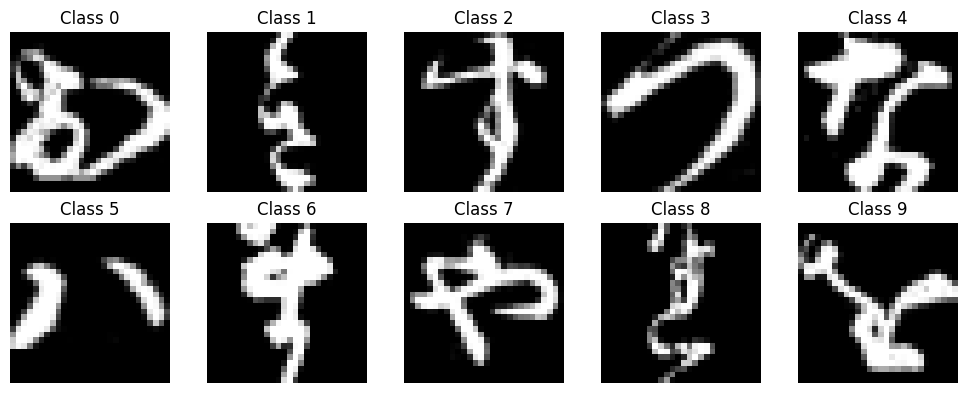

In [5]:
# 2. Exploratory Data Analysis – Descriptive statistics and sample images

unique, counts = np.unique(train_labels, return_counts=True)
print("\nClass distribution in training set:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    idx = np.where(train_labels == i)[0][0]
    axes[i // 5, i % 5].imshow(train_imgs[idx], cmap="gray")
    axes[i // 5, i % 5].set_title(f"Class {i}")
    axes[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()


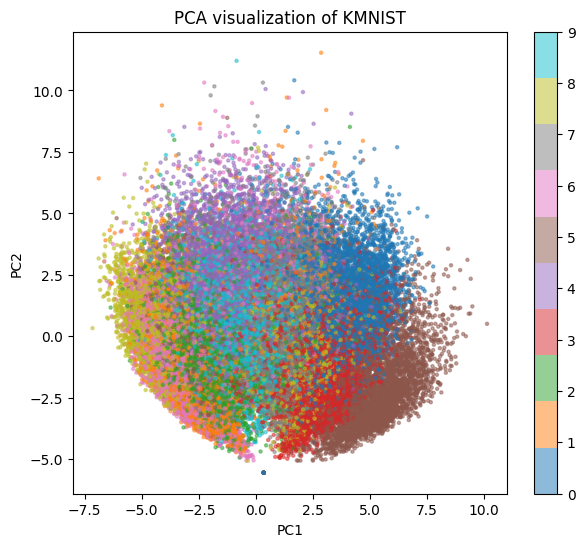

In [6]:
# 2. Exploratory Data Analysis – Dimensionality reduction (PCA)

from sklearn.decomposition import PCA

train_imgs_flat_for_pca = train_imgs.reshape(train_imgs.shape[0], -1) / 255.0
pca = PCA(n_components=2, random_state=SEED)
train_pca = pca.fit_transform(train_imgs_flat_for_pca)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1],
                      c=train_labels, cmap="tab10", alpha=0.5, s=5)
plt.colorbar(scatter)
plt.title("PCA visualization of KMNIST")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



Logistic Regression baseline:
Accuracy: 0.605


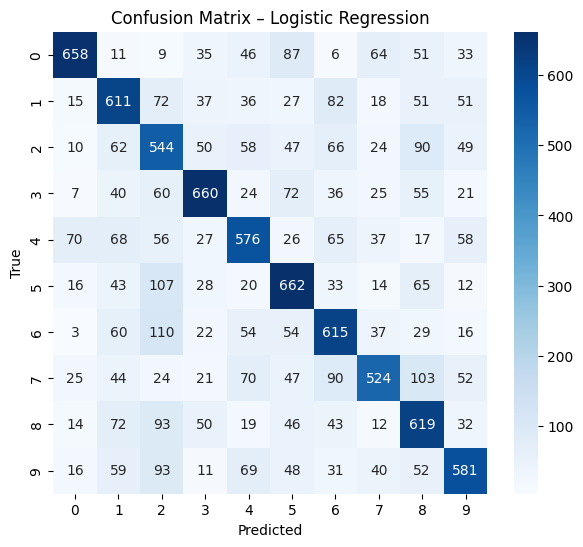

In [7]:
# 3. Model Selection – Baseline model: Logistic Regression

idx_subset = np.random.choice(len(X_train_flat), 10000, replace=False)
X_train_lr = X_train_flat[idx_subset]
y_train_lr = y_train[idx_subset]
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
logreg.fit(X_train_lr, y_train_lr)
y_test_pred_lr = logreg.predict(X_test_flat)

lr_acc = accuracy_score(y_test, y_test_pred_lr)
lr_prec = precision_score(y_test, y_test_pred_lr, average="weighted")
lr_rec = recall_score(y_test, y_test_pred_lr, average="weighted")
lr_f1 = f1_score(y_test, y_test_pred_lr, average="weighted")

print("\nLogistic Regression baseline:")
print("Accuracy:", lr_acc)

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [8]:
# 3. Model Selection – CNN architectures

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()
        if in_channels != out_channels:
            self.adjust = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.adjust = None

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        if self.adjust is not None:
            identity = self.adjust(identity)
        out += identity
        return self.relu(out)


class ResNetSimple(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = ResidualBlock(1, 32)
        self.pool = nn.MaxPool2d(2, 2)
        self.block2 = ResidualBlock(32, 64)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class ImprovedCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        if in_channels != out_channels:
            self.res_conv = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.res_conv = None

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.res_conv is not None:
            identity = self.res_conv(identity)
        out += identity
        return self.relu(out)


class ImprovedCNN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        self.block1 = ImprovedCNNBlock(1, 32)
        self.pool = nn.MaxPool2d(2, 2)
        self.block2 = ImprovedCNNBlock(32, 64)
        self.block3 = ImprovedCNNBlock(64, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)
        x = self.block2(x)
        x = self.pool(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


class TunedImprovedCNN(ImprovedCNN):
    def __init__(self, dropout_rate=0.4):
        super().__init__(dropout_rate=dropout_rate)


In [9]:
# 3. Model Selection – Training and evaluation helper functions

def train_model(model, train_loader, val_loader, device, epochs=5, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    best_val_loss = float("inf")
    best_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


def eval_model(model, loader, device, name="Dataset", show_cm=True):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="weighted")
    rec = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\n{name} classification report:")
    print(classification_report(all_labels, all_preds))

    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    return acc, prec, rec, f1, np.array(all_labels), np.array(all_preds)



Training Simple CNN
Epoch 1/5, Train Loss: 0.2974, Val Loss: 0.1341
Epoch 2/5, Train Loss: 0.0829, Val Loss: 0.0900
Epoch 3/5, Train Loss: 0.0420, Val Loss: 0.0912
Epoch 4/5, Train Loss: 0.0229, Val Loss: 0.1042
Epoch 5/5, Train Loss: 0.0160, Val Loss: 0.1104

Simple CNN – Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1000
           1       0.96      0.92      0.94      1000
           2       0.90      0.93      0.91      1000
           3       0.98      0.94      0.96      1000
           4       0.95      0.91      0.93      1000
           5       0.96      0.93      0.95      1000
           6       0.87      0.97      0.92      1000
           7       0.94      0.95      0.95      1000
           8       0.93      0.96      0.95      1000
           9       0.95      0.93      0.94      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94    

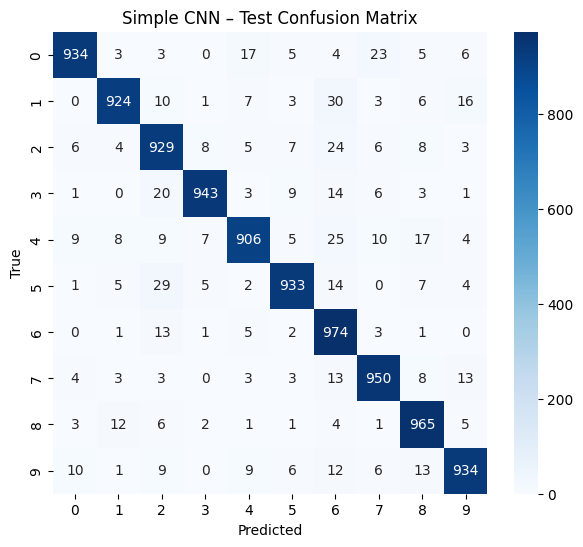

Simple CNN test accuracy: 0.9392


In [10]:
# 3. Model Selection – Train and evaluate Simple CNN

simple_cnn = SimpleCNN()
print("\nTraining Simple CNN")
simple_cnn = train_model(simple_cnn, train_loader, val_loader, DEVICE, epochs=5, lr=1e-3)
acc_sc, prec_sc, rec_sc, f1_sc, y_true_sc, y_pred_sc = eval_model(
    simple_cnn, test_loader, DEVICE, name="Simple CNN – Test"
)
print("Simple CNN test accuracy:", acc_sc)


Training ResNet-like CNN
Epoch 1/10, Train Loss: 0.3144, Val Loss: 0.1264
Epoch 2/10, Train Loss: 0.0813, Val Loss: 0.0986
Epoch 3/10, Train Loss: 0.0393, Val Loss: 0.1057
Epoch 4/10, Train Loss: 0.0247, Val Loss: 0.0908
Epoch 5/10, Train Loss: 0.0184, Val Loss: 0.0974
Epoch 6/10, Train Loss: 0.0147, Val Loss: 0.0906
Epoch 7/10, Train Loss: 0.0115, Val Loss: 0.1144
Epoch 8/10, Train Loss: 0.0120, Val Loss: 0.0960
Epoch 9/10, Train Loss: 0.0084, Val Loss: 0.1077
Epoch 10/10, Train Loss: 0.0084, Val Loss: 0.1119

ResNet-like CNN – Test classification report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1000
           1       0.98      0.92      0.95      1000
           2       0.95      0.89      0.91      1000
           3       0.95      0.97      0.96      1000
           4       0.90      0.93      0.91      1000
           5       0.95      0.93      0.94      1000
           6       0.90      0.98      0.94      1000
   

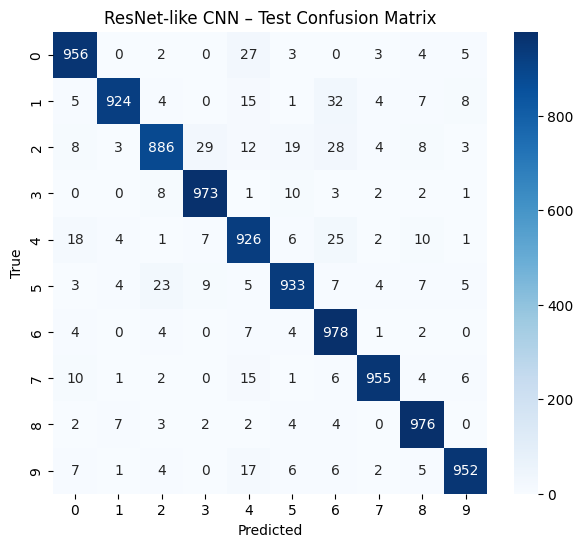

ResNet-like CNN test accuracy: 0.9459


In [11]:
# 3. Model Selection – Train and evaluate ResNet-like CNN

resnet_model = ResNetSimple()
print("\nTraining ResNet-like CNN")
resnet_model = train_model(resnet_model, train_loader, val_loader, DEVICE, epochs=10, lr=1e-3)
acc_res, prec_res, rec_res, f1_res, y_true_res, y_pred_res = eval_model(
    resnet_model, test_loader, DEVICE, name="ResNet-like CNN – Test"
)
print("ResNet-like CNN test accuracy:", acc_res)


Training Improved CNN
Epoch 1/10, Train Loss: 0.1933, Val Loss: 0.1046
Epoch 2/10, Train Loss: 0.0581, Val Loss: 0.0511
Epoch 3/10, Train Loss: 0.0362, Val Loss: 0.0366
Epoch 4/10, Train Loss: 0.0268, Val Loss: 0.0473
Epoch 5/10, Train Loss: 0.0229, Val Loss: 0.0391
Epoch 6/10, Train Loss: 0.0187, Val Loss: 0.0491
Epoch 7/10, Train Loss: 0.0165, Val Loss: 0.0325
Epoch 8/10, Train Loss: 0.0132, Val Loss: 0.0494
Epoch 9/10, Train Loss: 0.0145, Val Loss: 0.0360
Epoch 10/10, Train Loss: 0.0118, Val Loss: 0.0434

Improved CNN – Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1000
           1       0.98      0.96      0.97      1000
           2       0.96      0.95      0.95      1000
           3       0.99      0.98      0.99      1000
           4       0.96      0.96      0.96      1000
           5       0.98      0.96      0.97      1000
           6       0.94      0.99      0.97      1000
         

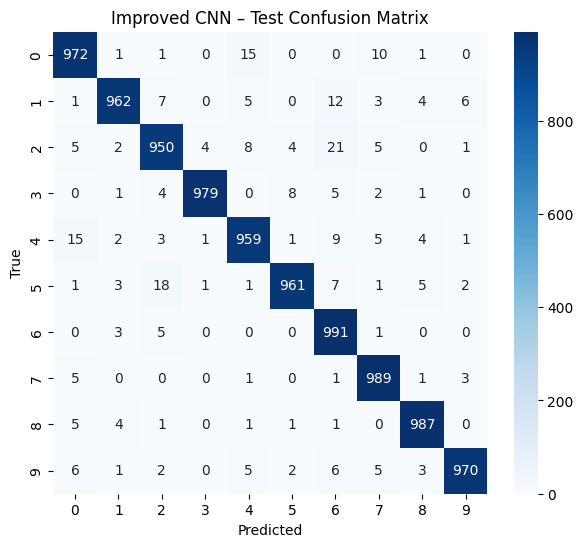

Improved CNN test accuracy: 0.972


In [12]:
# 3. Model Selection – Train and evaluate base Improved CNN

improved_model = ImprovedCNN(dropout_rate=0.4)
print("\nTraining Improved CNN")
improved_model = train_model(improved_model, train_loader, val_loader, DEVICE, epochs=10, lr=1e-3)
acc_imp, prec_imp, rec_imp, f1_imp, y_true_imp, y_pred_imp = eval_model(
    improved_model, test_loader, DEVICE, name="Improved CNN – Test"
)
print("Improved CNN test accuracy:", acc_imp)


In [13]:
# 3. Model Selection – Hyperparameter tuning for TunedImprovedCNN

learning_rates = [0.001, 0.0005]
dropout_rates = [0.3, 0.4, 0.5]
batch_sizes = [64, 128]

best_val_acc = 0.0
best_params = None

print("\nHyperparameter search for TunedImprovedCNN")

for lr in learning_rates:
    for dr in dropout_rates:
        for bs in batch_sizes:
            print(f"\nlr={lr}, dropout={dr}, batch_size={bs}")
            train_loader_hp = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            val_loader_hp = DataLoader(val_dataset, batch_size=bs, shuffle=False)

            model_hp = TunedImprovedCNN(dropout_rate=dr)
            model_hp = train_model(model_hp, train_loader_hp, val_loader_hp, DEVICE, epochs=3, lr=lr)

            model_hp.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for images, labels in val_loader_hp:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = model_hp(images)
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            val_acc = accuracy_score(all_labels, all_preds)
            print(f"Validation accuracy: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = (lr, dr, bs)

print("\nBest hyperparameters:", best_params, "with val acc", best_val_acc)

best_lr, best_dropout, best_batch_size = best_params



Hyperparameter search for TunedImprovedCNN

lr=0.001, dropout=0.3, batch_size=64
Epoch 1/3, Train Loss: 0.1787, Val Loss: 0.0672
Epoch 2/3, Train Loss: 0.0530, Val Loss: 0.0474
Epoch 3/3, Train Loss: 0.0322, Val Loss: 0.0325
Validation accuracy: 0.9900

lr=0.001, dropout=0.3, batch_size=128
Epoch 1/3, Train Loss: 0.2009, Val Loss: 0.1007
Epoch 2/3, Train Loss: 0.0547, Val Loss: 0.0545
Epoch 3/3, Train Loss: 0.0318, Val Loss: 0.0465
Validation accuracy: 0.9853

lr=0.001, dropout=0.4, batch_size=64
Epoch 1/3, Train Loss: 0.2024, Val Loss: 0.0715
Epoch 2/3, Train Loss: 0.0565, Val Loss: 0.0445
Epoch 3/3, Train Loss: 0.0386, Val Loss: 0.0439
Validation accuracy: 0.9862

lr=0.001, dropout=0.4, batch_size=128
Epoch 1/3, Train Loss: 0.2399, Val Loss: 0.1438
Epoch 2/3, Train Loss: 0.0592, Val Loss: 0.0474
Epoch 3/3, Train Loss: 0.0376, Val Loss: 0.0451
Validation accuracy: 0.9857

lr=0.001, dropout=0.5, batch_size=64
Epoch 1/3, Train Loss: 0.2228, Val Loss: 0.0696
Epoch 2/3, Train Loss: 0.066


Training final TunedImprovedCNN
Epoch 1/10, Train Loss: 0.2131, Val Loss: 0.0535
Best model updated.
Epoch 2/10, Train Loss: 0.0671, Val Loss: 0.0593
Epoch 3/10, Train Loss: 0.0440, Val Loss: 0.0414
Best model updated.
Epoch 4/10, Train Loss: 0.0309, Val Loss: 0.0356
Best model updated.
Epoch 5/10, Train Loss: 0.0251, Val Loss: 0.0364
Epoch 6/10, Train Loss: 0.0233, Val Loss: 0.0495
Epoch 7/10, Train Loss: 0.0197, Val Loss: 0.0382
Epoch 8/10, Train Loss: 0.0165, Val Loss: 0.0413
Epoch 9/10, Train Loss: 0.0151, Val Loss: 0.0400
Epoch 10/10, Train Loss: 0.0147, Val Loss: 0.0331
Best model updated.

Tuned Improved CNN – Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4807
           1       1.00      1.00      1.00      4791
           2       1.00      1.00      1.00      4814
           3       1.00      1.00      1.00      4750
           4       1.00      1.00      1.00      4812
           5       1

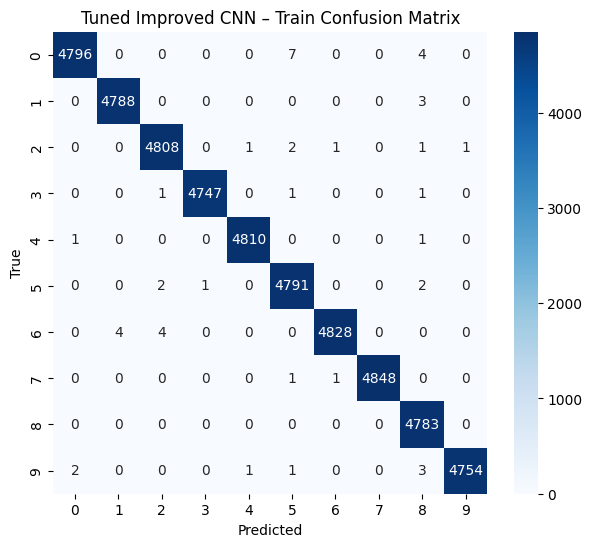


Tuned Improved CNN – Test classification report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1000
           1       0.99      0.96      0.98      1000
           2       0.94      0.96      0.95      1000
           3       0.98      0.98      0.98      1000
           4       0.96      0.95      0.95      1000
           5       0.98      0.95      0.97      1000
           6       0.96      0.98      0.97      1000
           7       0.98      0.99      0.98      1000
           8       0.95      0.99      0.97      1000
           9       0.99      0.98      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



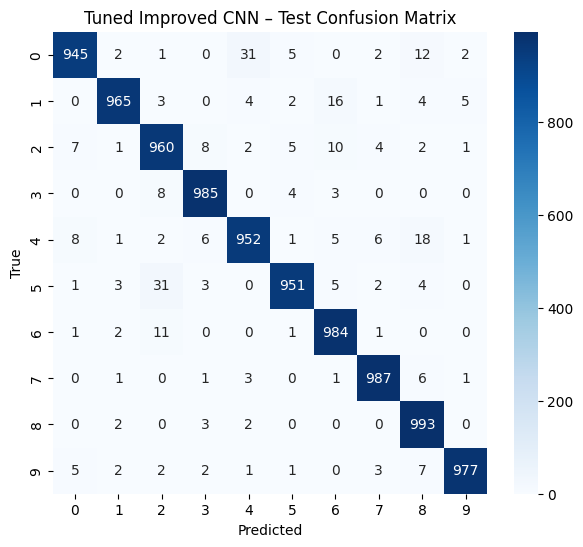

Final TunedImprovedCNN train accuracy: 0.9990208333333334
Final TunedImprovedCNN test accuracy: 0.9699


In [14]:
# 3. Model Selection – Final training and evaluation of TunedImprovedCNN

train_loader_best = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader_best = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)
test_loader_best = DataLoader(TensorDataset(test_imgs_tensor, test_labels_tensor),
                              batch_size=best_batch_size, shuffle=False)

final_model = TunedImprovedCNN(dropout_rate=best_dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr)
final_model.to(DEVICE)

best_val_loss = float("inf")
best_state = None

print("\nTraining final TunedImprovedCNN")

for epoch in range(10):
    final_model.train()
    running_loss = 0.0
    for images, labels in train_loader_best:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader_best.dataset)

    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader_best:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = final_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader_best.dataset)

    print(f"Epoch {epoch+1}/10, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = final_model.state_dict()
        torch.save(best_state, "best_tuned_improved_cnn.pth")
        print("Best model updated.")

if best_state is not None:
    final_model.load_state_dict(best_state)

acc_train_final, prec_train_final, rec_train_final, f1_train_final, y_true_train_final, y_pred_train_final = eval_model(
    final_model, train_loader_best, DEVICE, name="Tuned Improved CNN – Train"
)
acc_test_final, prec_test_final, rec_test_final, f1_test_final, y_true_test_final, y_pred_test_final = eval_model(
    final_model, test_loader_best, DEVICE, name="Tuned Improved CNN – Test"
)

print("Final TunedImprovedCNN train accuracy:", acc_train_final)
print("Final TunedImprovedCNN test accuracy:", acc_test_final)


Misclassified examples for TunedImprovedCNN:


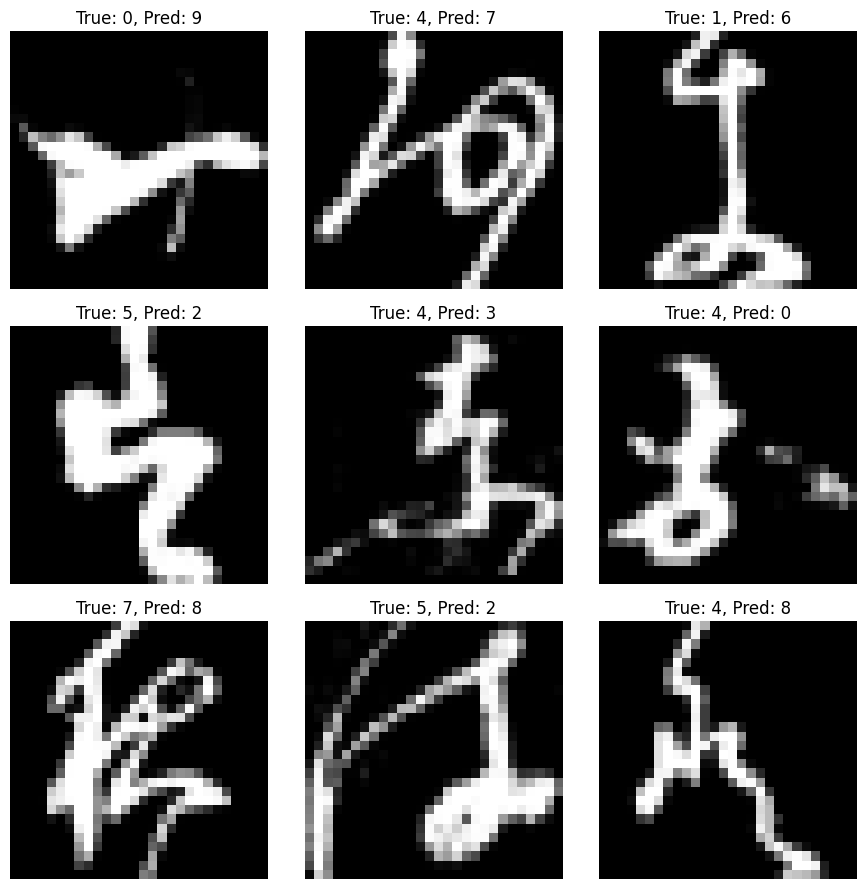

In [15]:
# Interpretability – show some misclassified test examples for TunedImprovedCNN

def plot_misclassified_examples(model, loader, device, n=9):
    model.eval()
    images_list = []
    true_list = []
    pred_list = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            mism = preds != labels
            if mism.any():
                for img, t, p, m in zip(images, labels, preds, mism):
                    if m.item():
                        images_list.append(img.cpu().squeeze().numpy())
                        true_list.append(t.item())
                        pred_list.append(p.item())
                        if len(images_list) >= n:
                            break
            if len(images_list) >= n:
                break

    rows = int(np.ceil(n / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(9, 3 * rows))
    axes = axes.flatten()
    for i in range(n):
        axes[i].imshow(images_list[i], cmap="gray")
        axes[i].set_title(f"True: {true_list[i]}, Pred: {pred_list[i]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

print("\nMisclassified examples for TunedImprovedCNN:")
plot_misclassified_examples(final_model, test_loader_best, DEVICE, n=9)

In [16]:
# 3. Model Selection – Aggregated metrics / model comparison

metrics = [
    {"Model": "Logistic Regression", "Accuracy": lr_acc, "Precision": lr_prec,
     "Recall": lr_rec, "F1-score": lr_f1},
    {"Model": "Simple CNN", "Accuracy": acc_sc, "Precision": prec_sc,
     "Recall": rec_sc, "F1-score": f1_sc},
    {"Model": "ResNet-like CNN", "Accuracy": acc_res, "Precision": prec_res,
     "Recall": rec_res, "F1-score": f1_res},
    {"Model": "Improved CNN", "Accuracy": acc_imp, "Precision": prec_imp,
     "Recall": rec_imp, "F1-score": f1_imp},
    {"Model": "Tuned Improved CNN", "Accuracy": acc_test_final, "Precision": prec_test_final,
     "Recall": rec_test_final, "F1-score": f1_test_final},
]

metrics_df = pd.DataFrame(metrics).sort_values(by="Accuracy", ascending=False)
print("\nModel comparison:")
print(metrics_df)


Model comparison:
                 Model  Accuracy  Precision  Recall  F1-score
3         Improved CNN    0.9720   0.972266  0.9720  0.972015
4   Tuned Improved CNN    0.9699   0.970160  0.9699  0.969892
2      ResNet-like CNN    0.9459   0.946717  0.9459  0.945892
1           Simple CNN    0.9392   0.940447  0.9392  0.939354
0  Logistic Regression    0.6050   0.613722  0.6050  0.606925


Collected 3 examples for saliency visualization


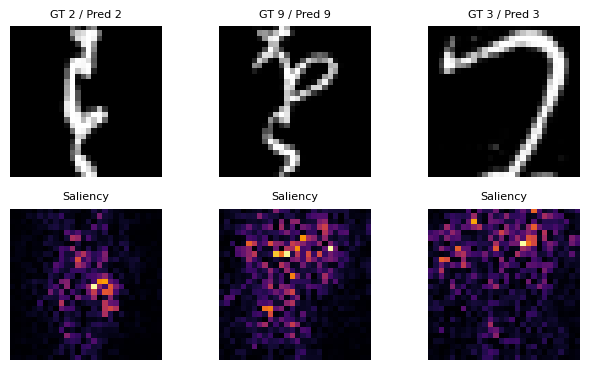

In [17]:
# 4. Model Interpretability – 2x3 figure (3 examples, top row = images, bottom row = saliency)

import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Rebuild TunedImprovedCNN and load the best parameters (if this was already done above, this block can be omitted)
try:
    dropout_for_interp = best_dropout
except NameError:
    dropout_for_interp = 0.5  # best value selected from your grid search

model_interp = TunedImprovedCNN(dropout_rate=dropout_for_interp).to(DEVICE)
state_dict = torch.load("best_tuned_improved_cnn.pth", map_location=DEVICE)
model_interp.load_state_dict(state_dict)
model_interp.eval()

# 2. Function to compute saliency (with respect to the predicted-class logit)
def collect_saliency_maps(model, data_loader, device, n=3):
    """
    Take the first n samples from data_loader and compute gradient-based saliency maps
    with respect to the predicted-class logit.
    Return: images_list (n, 28, 28), labels_list, preds_list, saliency_list (n, 28, 28)
    """
    model.eval()
    images_list = []
    labels_list = []
    preds_list = []
    saliency_list = []

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        images.requires_grad_()  # enable gradients on the input images

        model.zero_grad()
        outputs = model(images)  # (B, 10)
        preds = outputs.argmax(dim=1)

        # For each sample: take the logit corresponding to the predicted class as the score
        scores = outputs[torch.arange(outputs.size(0)), preds]

        # Sum the scores over the whole batch and backpropagate once
        scores.sum().backward()

        # saliency: take the maximum absolute value over the channel dimension to get (B, 28, 28)
        saliency = images.grad.detach().abs().max(dim=1)[0]

        for i in range(images.size(0)):
            images_list.append(images[i].detach().cpu().squeeze(0).numpy())
            labels_list.append(int(labels[i].cpu()))
            preds_list.append(int(preds[i].cpu()))
            saliency_list.append(saliency[i].cpu().numpy())
            if len(images_list) >= n:
                return images_list, labels_list, preds_list, saliency_list

    return images_list, labels_list, preds_list, saliency_list


# 3. Take 3 samples and plot a 2x3 grid (top row: original images, bottom row: corresponding saliency maps)
num_examples = 3
images_list, labels_list, preds_list, saliency_list = collect_saliency_maps(
    model_interp, test_loader_best, DEVICE, n=num_examples
)

print(f"Collected {len(images_list)} examples for saliency visualization")

rows, cols = 2, num_examples
fig, axes = plt.subplots(rows, cols, figsize=(2.2 * cols, 3.8))

for j in range(num_examples):
    # ---------- Top row: original input image ----------
    ax_img = axes[0, j]
    ax_img.imshow(images_list[j], cmap="gray", interpolation="nearest")
    gt = labels_list[j]
    pred = preds_list[j]
    title = f"GT {gt} / Pred {pred}"
    ax_img.set_title(title, fontsize=8)
    ax_img.axis("off")

    # ---------- Bottom row: corresponding saliency heatmap ----------
    ax_sal = axes[1, j]
    s = saliency_list[j]
    # Normalize each saliency map individually to [0, 1]
    s = (s - s.min()) / (s.max() - s.min() + 1e-8)
    ax_sal.imshow(s, cmap="inferno", interpolation="nearest")
    ax_sal.set_title("Saliency", fontsize=8)
    ax_sal.axis("off")

plt.tight_layout()
plt.savefig("cnn_saliency_2x3.png", dpi=300, bbox_inches="tight")
plt.show()


In [21]:
# ============================================================
# Siamese Network for One-Shot Image Recognition (Koch et al. 2015 style)
# On KMNIST/MNIST:
#   1) Train a Siamese CNN for binary "same / different" classification (pairwise)
#   2) Use the learned embedding for 10-way one-shot classification:
#      1 support image per class, assign each test image to the nearest class in embedding space
#   3) Compute Acc / Prec / Rec / F1 (macro) on the one-shot results to align with the report metrics
#
# Dependencies:
#   - train_imgs: numpy (N_train, 28, 28), dtype uint8
#   - train_labels: numpy (N_train,)
#   - test_imgs:  numpy (N_test, 28, 28)
#   - test_labels: numpy (N_test,)
#   - DEVICE, SEED already exist (will be defined here if not)
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ---------- Common settings ----------
try:
    DEVICE
except NameError:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    SEED
except NameError:
    SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------- General metric function: aligned with Table I in the report ----------

def compute_metrics(y_true, y_pred):
    """
    Compute:
      - accuracy
      - macro precision / recall / F1
    Return: (acc, prec, rec, f1)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return acc, prec, rec, f1


# ---------- Siamese Pair Dataset ----------

class SiamesePairDataset(Dataset):
    """
    On-the-fly generation of (img1, img2, label) pairs:
        label = 1  -> same class
        label = 0  -> different class
    """
    def __init__(self, imgs, labels, same_prob=0.5):
        self.imgs = imgs
        self.labels = labels
        self.same_prob = same_prob

        self.num_classes = int(labels.max()) + 1
        self.class_to_indices = {
            c: np.where(labels == c)[0] for c in range(self.num_classes)
        }
        self.indices = np.arange(len(labels))

    def __len__(self):
        # Return a reasonably large value to indicate we can sample "infinitely";
        # typically the DataLoader controls the number of iterations per epoch
        return len(self.imgs)

    def __getitem__(self, idx):
        # Randomly pick one anchor from all samples
        idx1 = np.random.choice(self.indices)
        img1 = self.imgs[idx1]
        label1 = self.labels[idx1]

        # Decide same / different
        if np.random.rand() < self.same_prob:
            # same class
            idx2 = np.random.choice(self.class_to_indices[label1])
            y = 1.0
        else:
            # different class
            diff_classes = list(range(self.num_classes))
            diff_classes.remove(label1)
            label2 = np.random.choice(diff_classes)
            idx2 = np.random.choice(self.class_to_indices[label2])
            y = 0.0

        img2 = self.imgs[idx2]

        # Convert to tensor and normalize to [0,1]
        x1 = torch.from_numpy(img1.astype(np.float32) / 255.0).unsqueeze(0)  # (1,28,28)
        x2 = torch.from_numpy(img2.astype(np.float32) / 255.0).unsqueeze(0)
        y = torch.tensor([y], dtype=torch.float32)  # (1,)

        return x1, x2, y


# ---------- Siamese CNN (Koch-style, slightly simplified) ----------

class SiameseConvNet(nn.Module):
    """
    The one-shot architecture in Koch et al. can be summarized as:
      conv(64) -> pool -> conv(128) -> pool -> conv(128) -> pool -> conv(256) -> pool -> FC(4096)
    Here we use a slightly smaller network (since 28x28 is smaller than the original Omniglot images),
    and the embedding_dim is configurable.
    """
    def __init__(self, embedding_dim=256):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                   # 14x14

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                   # 7x7

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                   # 3x3 (floor)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, embedding_dim),
            nn.ReLU(inplace=True)
        )

        # For final similarity-based binary classification, use a simple fully connected layer + sigmoid
        self.classifier = nn.Linear(embedding_dim, 1)

    def encode(self, x):
        h = self.features(x)
        z = self.fc(h)
        return z  # (B, embedding_dim)

    def forward_once(self, x):
        return self.encode(x)

    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        # Use L1 distance + FC to score similarity (Koch's paper uses a similar method)
        diff = torch.abs(z1 - z2)
        logit = self.classifier(diff)  # (B,1)
        return logit.view(-1), z1, z2  # Return 1D logits for BCEWithLogitsLoss


# ---------- Train the Siamese network ----------

print("=== Stage 1: Train SiameseConvNet on pairwise same/different task ===")

pair_dataset = SiamesePairDataset(train_imgs, train_labels, same_prob=0.5)
pair_loader = DataLoader(pair_dataset, batch_size=128, shuffle=True)

siamese = SiameseConvNet(embedding_dim=256).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(siamese.parameters(), lr=1e-3)

num_epochs = 10  # You can increase to 15/20 depending on available time

for epoch in range(num_epochs):
    siamese.train()
    running_loss = 0.0
    for x1, x2, y in pair_loader:
        x1 = x1.to(DEVICE)
        x2 = x2.to(DEVICE)
        y = y.to(DEVICE).view(-1)  # (B,)

        optimizer.zero_grad()
        logits, _, _ = siamese(x1, x2)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x1.size(0)

    avg_loss = running_loss / len(pair_dataset)
    print(f"[Siamese] Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}")


# ---------- One-shot evaluation function (10-way, 1 support per class, with four metrics) ----------

def one_shot_evaluation(
    siamese_model,
    train_imgs, train_labels,
    test_imgs,  test_labels,
    num_classes=10,
    num_support_per_class=1,
    max_test=None,
):
    """
    10-way one-shot:
      - For each class, randomly choose num_support_per_class support images (default 1 image)
      - For each test image:
          * Use the encoder to extract an embedding
          * Compute the L2 distance to each class prototype
          * Predict the class with the smallest distance
      - Return: (acc, prec, rec, f1, preds, true_labels, prototypes)
    """
    siamese_model.eval()

    # 1. Select support set
    support_indices = []
    rng = np.random.RandomState(SEED + 123)
    for c in range(num_classes):
        cls_idx = np.where(train_labels == c)[0]
        chosen = rng.choice(cls_idx, size=num_support_per_class, replace=False)
        support_indices.extend(chosen.tolist())
    support_indices = np.array(support_indices, dtype=int)

    support_imgs = train_imgs[support_indices]   # (num_classes * num_support,28,28)
    support_labels = train_labels[support_indices]

    # 2. Extract support embeddings and average them per class to obtain prototypes
    support_tensors = torch.from_numpy(
        support_imgs.astype(np.float32) / 255.0
    ).unsqueeze(1).to(DEVICE)  # (N_s,1,28,28)

    with torch.no_grad():
        support_z = siamese_model.encode(support_tensors).cpu().numpy()  # (N_s, D)

    prototypes = []
    for c in range(num_classes):
        cls_feats = support_z[support_labels == c]
        proto = cls_feats.mean(axis=0)
        prototypes.append(proto)
    prototypes = np.stack(prototypes, axis=0)  # (C,D)

    # 3. Perform one-shot classification on the test set
    if max_test is None:
        max_test = len(test_imgs)
    max_test = min(max_test, len(test_imgs))

    test_subset_imgs = test_imgs[:max_test]
    test_subset_labels = test_labels[:max_test]

    test_tensors = torch.from_numpy(
        test_subset_imgs.astype(np.float32) / 255.0
    ).unsqueeze(1).to(DEVICE)  # (N_t,1,28,28)

    with torch.no_grad():
        test_z = siamese_model.encode(test_tensors).cpu().numpy()  # (N_t,D)

    # L2 distance to each prototype
    diff = test_z[:, None, :] - prototypes[None, :, :]  # (N_t,C,D)
    dists = np.sum(diff ** 2, axis=2)                  # (N_t,C)
    preds = np.argmin(dists, axis=1)

    # Compute the four metrics
    acc, prec, rec, f1 = compute_metrics(test_subset_labels, preds)

    return acc, prec, rec, f1, preds, test_subset_labels, prototypes


print("\n=== Stage 2: 10-way one-shot evaluation (1 support per class, full test set) ===")
acc_1s, prec_1s, rec_1s, f1_1s, preds_1s, true_labels_1s, prototypes_1s = one_shot_evaluation(
    siamese_model=siamese,
    train_imgs=train_imgs,
    train_labels=train_labels,
    test_imgs=test_imgs,
    test_labels=test_labels,
    num_classes=10,
    num_support_per_class=1,
    max_test=None,      # full 10000 test images
)

print(f"[One-shot 10-way] Acc={acc_1s:.4f}, Prec={prec_1s:.4f}, "
      f"Rec={rec_1s:.4f}, F1={f1_1s:.4f}")


=== Stage 1: Train SiameseConvNet on pairwise same/different task ===
[Siamese] Epoch 1/10, Train Loss: 0.4082
[Siamese] Epoch 2/10, Train Loss: 0.2121
[Siamese] Epoch 3/10, Train Loss: 0.1416
[Siamese] Epoch 4/10, Train Loss: 0.1036
[Siamese] Epoch 5/10, Train Loss: 0.0843
[Siamese] Epoch 6/10, Train Loss: 0.0698
[Siamese] Epoch 7/10, Train Loss: 0.0638
[Siamese] Epoch 8/10, Train Loss: 0.0524
[Siamese] Epoch 9/10, Train Loss: 0.0445
[Siamese] Epoch 10/10, Train Loss: 0.0430

=== Stage 2: 10-way one-shot evaluation (1 support per class, full test set) ===
[One-shot 10-way] Acc=0.7387, Prec=0.8036, Rec=0.7387, F1=0.7338
